In [1]:
# Plotting and EDA libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Neural Networks
import torch

from tqdm.auto import tqdm

# BERT utils
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Dataset
from datasets import load_dataset

In [2]:
plt.rcParams['figure.figsize'] = [13, 6]

In [3]:
# Set seeds for all libraries

GLOBAL_SEED = 1000

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(GLOBAL_SEED)

In [4]:
IMG_DIR = "images"

RED = '#bd6464'
BLUE = '#6883b3'
GREEN = '#99bd75'
ORANGE = '#b08953'
ORANGE_SAT = '#ff9900'

BAR_COLORS = [RED, BLUE]

In [5]:
if not os.path.exists(IMG_DIR): os.mkdir(IMG_DIR)

## Data Loading and Preprocessing

In [6]:
dataset = load_dataset("imdb")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
sample_map = [
    (0, "Negative"),
    (1, "Positive")
]

In [9]:
# Show a sample each of positive and negative reviews

def print_samples(test_train_split):
    for i, label in sample_map:
        for index, sample in enumerate(dataset[test_train_split]):
            if sample['label'] == i:
                print(f"{label} Sample Text (Label {sample['label']}): {sample['text'][:50]}...{sample['text'][-50:]}")
                break

In [10]:
print_samples('train')

Negative Sample Text (Label 0): I rented I AM CURIOUS-YELLOW from my video store b...But really, this film doesn't have much of a plot.
Positive Sample Text (Label 1): Zentropa has much in common with The Third Man, an... sun shine. Grim, but intriguing, and frightening.


In [11]:
print_samples('test')

Negative Sample Text (Label 0): I love sci-fi and am willing to put up with a lot....ck as another actor. Jeeez! Dallas all over again.
Positive Sample Text (Label 1): Previous reviewer Claudio Carvalho gave a much bet...n be in that mood all the time, so, overall, 8.75.


In [12]:
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])

In [13]:
train.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [14]:
test.head()

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [15]:
def plot_distribution(train_test_split):

    label_counts = train_test_split['label'].value_counts()

    plt.bar(x = label_counts.index, height = label_counts.values, color = BAR_COLORS)

    plt.title('Labels Distribution in Training Data')
    plt.xlabel('Labels')
    plt.ylabel('Count')

    plt.xticks(ticks = [0, 1], labels = ['Negative', 'Positive'])

    plt.show()

    return label_counts

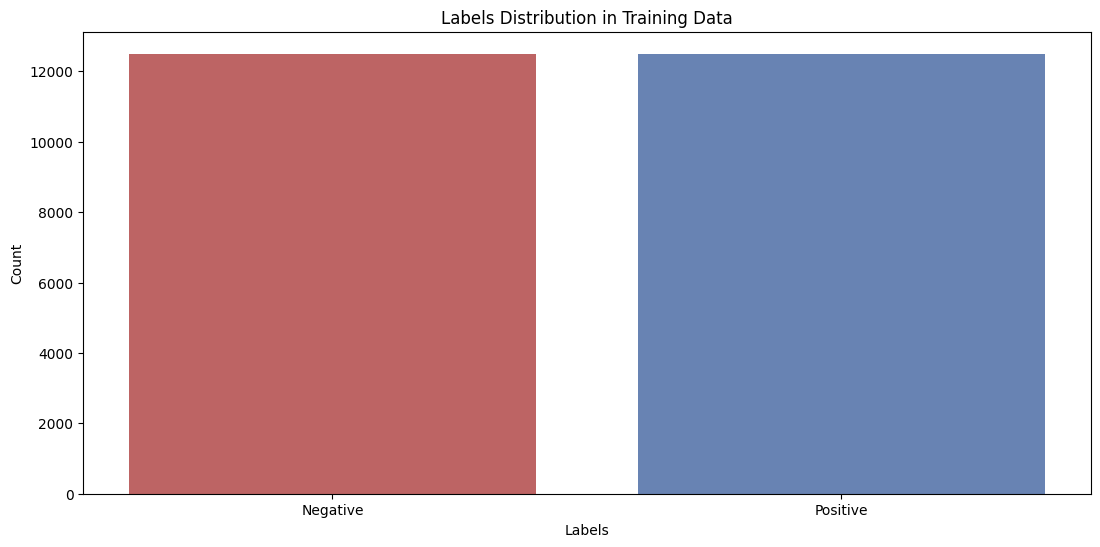

In [16]:
train_label_counts = plot_distribution(train)

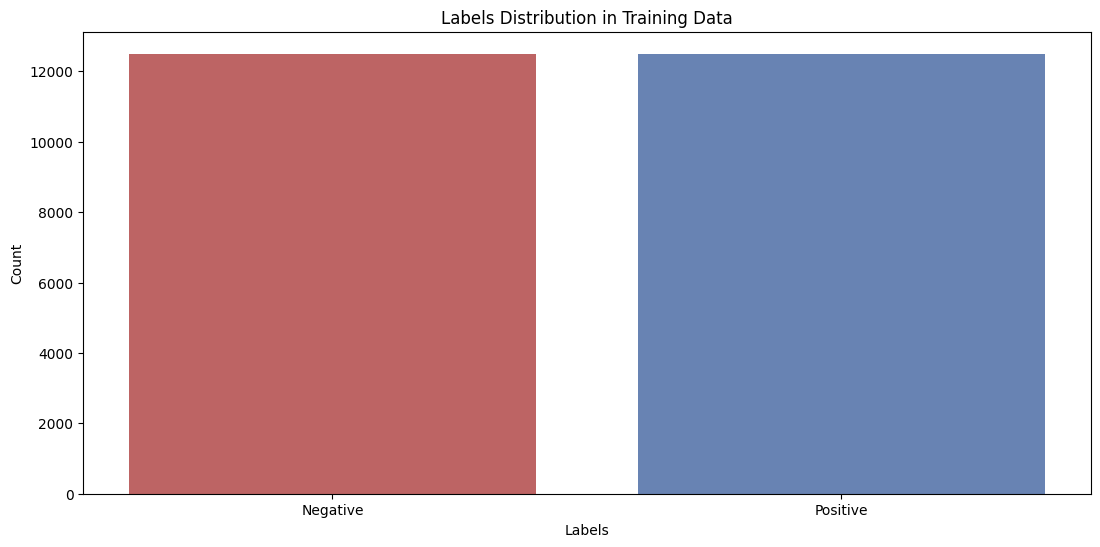

In [17]:
test_label_counts = plot_distribution(test)

In [18]:
print(f"Train Labels: {train_label_counts}\n Test Labels: {test_label_counts}\n ")

Train Labels: label
0    12500
1    12500
Name: count, dtype: int64
 Test Labels: label
0    12500
1    12500
Name: count, dtype: int64
 


Dataset Balance. Reviews are 50% positive, 50% negative.

In [19]:
train['text_length'] = train['text'].apply(len)
test['text_length'] = test['text'].apply(len)

In [20]:
train['text_length'].describe()

,text_length
count,25000.00000
mean,1325.06964
std,1003.13367
min,52.00000
25%,702.00000
50%,979.00000
75%,1614.00000
max,13704.00000


In [21]:
test['text_length'].describe()

,text_length
count,25000.00000
mean,1293.79240
std,975.90776
min,32.00000
25%,696.00000
50%,962.00000
75%,1572.00000
max,12988.00000


In [22]:
train_med = train['text_length'].median()
test_med = test['text_length'].median()

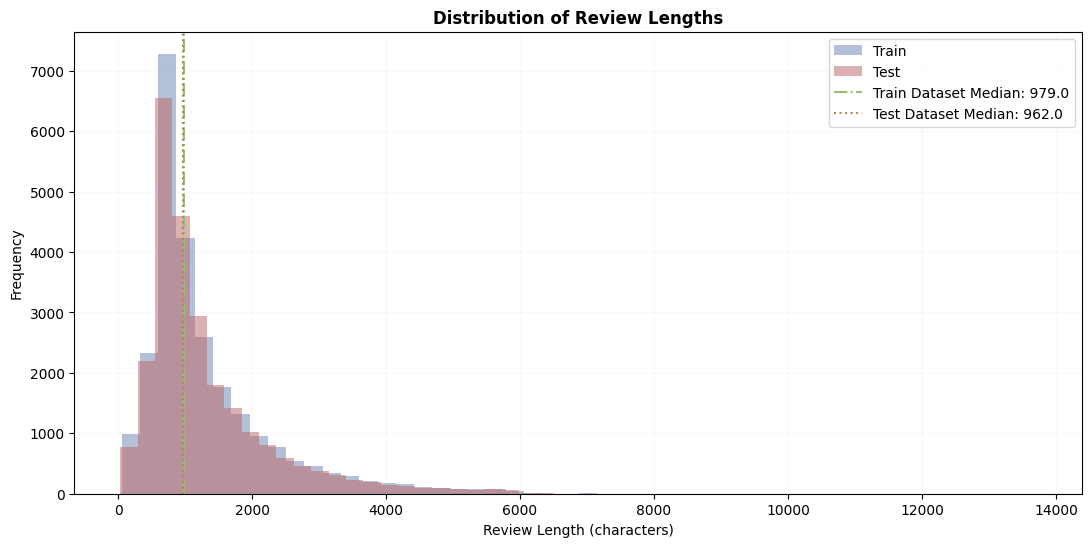

In [23]:
plt.hist(train['text_length'], bins = 50, alpha = 0.5, label = 'Train', color = BLUE)
plt.hist(test['text_length'], bins = 50, alpha = 0.5, label = 'Test', color = RED)

plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')

plt.title('Distribution of Review Lengths', fontsize=12, fontweight='bold')

plt.axvline(train_med, color = GREEN, alpha = 1, linestyle = '-.',
            label = f"Train Dataset Median: {train_med}")
plt.axvline(test_med, color = ORANGE, alpha = 1, linestyle = ':',
            label = f"Test Dataset Median: {test_med}")

plt.grid(alpha = 0.075)

plt.legend()

plt.savefig(f'{IMG_DIR}/text_length_distribution.png')

plt.show()

## Tokenization

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
rand_sample = train.loc[train['text_length'] < 150, 'text'].iloc[1]

In [26]:
print(f"Original Text: \"{rand_sample}\"")

Original Text: "You'd better choose Paul Verhoeven's even if you have watched it."


In [27]:
tokens = tokenizer.tokenize(rand_sample)

In [28]:
print(f"{tokens[:5]}...")
print(f"Tokens Length: {len(tokens)}")

['you', "'", 'd', 'better', 'choose']...
Tokens Length: 19


In [29]:
token_ids = tokenizer.encode(rand_sample, add_special_tokens = True)

In [30]:
print(f"{token_ids[:5]}...")
print(f"Encoded Tokens Length: {len(token_ids)}")

[101, 2017, 1005, 1040, 2488]...
Encoded Tokens Length: 21


In [31]:
decoded_tokens = tokenizer.decode(token_ids)
print(f"{decoded_tokens}...")

[CLS] you'd better choose paul verhoeven's even if you have watched it. [SEP]...


Creating Dataset Class

In [32]:
class ReviewDataset(Dataset):
    """
    Uses the BERT Tokenizer to Tokenize Text
    and prepare data in BERT format
    """

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, id):
        text = str(self.texts[id])
        label = self.labels[id]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = self.max_length,
            return_token_type_ids = False,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype = torch.long)
        }

In [33]:
train_ds = ReviewDataset(
    texts = train['text'].tolist(),
    labels = train['label'].tolist(),
    tokenizer = tokenizer,
    max_length = 512
)

test_ds = ReviewDataset(
    texts = test['text'].tolist(),
    labels = test['label'].tolist(),
    tokenizer = tokenizer,
    max_length = 512
)

In [34]:
print(len(train_ds))
print(len(test_ds))

25000
25000


In [35]:
train_loader = DataLoader(
    train_ds,
    batch_size = 8,
    shuffle = True,
    num_workers = 2
)

test_loader = DataLoader(
    test_ds,
    batch_size = 8,
    shuffle = False,
    num_workers = 2
)

In [36]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
optimizer = AdamW(
    model.parameters(),
    lr = 0.001,
    eps = 1e-8,  # Epsilon for numerical stability
    weight_decay = 0.01
)

In [38]:
sum_steps = len(train_loader) * 3
warmup_steps = 500

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = warmup_steps,
    num_training_steps = sum_steps
)

In [39]:
# For Tracking Traning Progress
training_stats = []

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
# Ensure the model is also moved to the determined device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [42]:
print(f"Initiating traning using: {device}...")

Initiating traning using: cuda...


In [43]:
for epoch in range(3):

    model.train()

    # For tracking training progress
    total_train_loss = 0
    train_predictions = []
    train_true_labels = []

    print(f"Epoch {epoch + 1}/{3} - Training...")

    for batch_num, batch in enumerate(train_loader):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        model.zero_grad()

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            labels = labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        scheduler.step()

        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim = 1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        train_predictions.extend(preds)
        train_true_labels.extend(labels_cpu)

        if (batch_num + 1) % 10 == 0:
            print(f"Batch {batch_num + 1}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_true_labels, train_predictions)

    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")

    print("Evaluating on test set...")

    # Model Evaluation
    model.eval()

    total_val_loss = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch_num, batch in enumerate(test_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels_cpu = labels.cpu().numpy()

            val_predictions.extend(preds)
            val_true_labels.extend(labels_cpu)

            if (batch_num + 1) % 10 == 0:
                print(f"Batch {batch_num + 1}/{len(test_loader)}")

    avg_val_loss = total_val_loss / len(test_loader)
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        val_true_labels,
        val_predictions,
        average = 'binary'
    )

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f}")

    # Storing stats for later plotting and persisting (saving) to storage
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': avg_val_loss,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })

Epoch 1/3 - Training...
Batch 10/3125 - Loss: 0.6529
Batch 20/3125 - Loss: 0.6681
Batch 30/3125 - Loss: 0.6527
Batch 40/3125 - Loss: 0.6199
Batch 50/3125 - Loss: 0.6419
Batch 60/3125 - Loss: 0.2820
Batch 70/3125 - Loss: 0.5302
Batch 80/3125 - Loss: 1.2388
Batch 90/3125 - Loss: 0.5972
Batch 100/3125 - Loss: 0.5422
Batch 110/3125 - Loss: 0.6136
Batch 120/3125 - Loss: 0.5748
Batch 130/3125 - Loss: 0.9103
Batch 140/3125 - Loss: 0.5601
Batch 150/3125 - Loss: 0.6740
Batch 160/3125 - Loss: 0.8769
Batch 170/3125 - Loss: 0.8854
Batch 180/3125 - Loss: 0.7797
Batch 190/3125 - Loss: 0.7079
Batch 200/3125 - Loss: 0.6724
Batch 210/3125 - Loss: 0.7026
Batch 220/3125 - Loss: 0.6971
Batch 230/3125 - Loss: 0.6983
Batch 240/3125 - Loss: 0.7141
Batch 250/3125 - Loss: 0.6236
Batch 260/3125 - Loss: 0.6232
Batch 270/3125 - Loss: 0.6991
Batch 280/3125 - Loss: 0.6444
Batch 290/3125 - Loss: 0.7682
Batch 300/3125 - Loss: 1.0645
Batch 310/3125 - Loss: 0.6855
Batch 320/3125 - Loss: 0.7821
Batch 330/3125 - Loss: 0.

KeyboardInterrupt: 

In [44]:
y_train = train['label'].tolist()
X_train = train['text'].tolist()
y_test = test['label'].tolist()
X_test = test['text'].tolist()

In [45]:
tfidf = TfidfVectorizer(
    max_features = 5000,
    ngram_range = (1, 2),
    min_df = 5
)

In [46]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [47]:
feature_names = tfidf.get_feature_names_out()

In [48]:
lr_model = LogisticRegression(
    max_iter = 1000,
    random_state = GLOBAL_SEED,
    n_jobs = -1
)

In [49]:
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1000)

In [50]:
lr_predictions = lr_model.predict(X_test_tfidf)

In [51]:
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(
    y_test,
    lr_predictions,
    average = 'binary'
)

In [52]:
print("Logistics Regression Results")
print(f"Precision: {lr_precision:.4f}")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")

Logistics Regression Results
Precision: 0.8837
Accuracy: 0.8881
Recall: 0.8938
F1-Score: 0.8887


In [53]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [54]:
nb_predictions = nb_model.predict(X_test_tfidf)

In [55]:
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(
    y_test,
    nb_predictions,
    average = 'binary'
)

In [56]:
print("Naive Bayes Results")
print(f"Precision: {nb_precision:.4f}")
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Recall: {nb_recall:.4f}")
print(f"F1-Score: {nb_f1:.4f}")

Naive Bayes Results
Precision: 0.8526
Accuracy: 0.8552
Recall: 0.8589
F1-Score: 0.8557


In [57]:
stats_df = pd.DataFrame(training_stats)

stats_output_path = os.path.join(IMG_DIR, 'bert_training_stats.csv')
stats_df.to_csv(stats_output_path, index = False)

print(f"Training statistics saved to {stats_output_path}")

Training statistics saved to images/bert_training_stats.csv


In [58]:
model.eval()
bert_predictions = []
bert_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc = "BERT Inference"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim = 1).cpu().numpy()

        bert_predictions.extend(preds)
        bert_true_labels.extend(labels.cpu().numpy())


bert_accuracy = accuracy_score(bert_true_labels, bert_predictions)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    bert_true_labels,
    bert_predictions,
    average = 'binary'
)

print(f"BERT Results:")
print(f"Accuracy: {bert_accuracy:.4f}")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall: {bert_recall:.4f}")
print(f"F1-Score: {bert_f1:.4f}")

BERT Inference:   0%|          | 0/3125 [00:00<?, ?it/s]

BERT Results:
Accuracy:  0.5000
Precision: 0.5000
Recall:    1.0000
F1-Score:  0.6667


In [59]:
model_output_dir = os.path.join(IMG_DIR, 'fine_tuned_bert_model')

os.makedirs(model_output_dir, exist_ok=True)

model.save_pretrained(model_output_dir)

print(f"Fine-tuned BERT model saved to: {model_output_dir}")

Fine-tuned BERT model saved to: images/fine_tuned_bert_model


In [62]:
def compare_models():

    comparison_df = pd.DataFrame({
        'Model': ['Logistic Regression', 'Naive Bayes', 'BERT (Fine-tuned)'],
        'Accuracy': [lr_accuracy, nb_accuracy, bert_accuracy],
        'Precision': [lr_precision, nb_precision, bert_precision],
        'Recall': [lr_recall, nb_recall, bert_recall],
        'F1-Score': [lr_f1, nb_f1, bert_f1]
    })

    print(comparison_df.to_string(index = False))

    comparison_df.to_csv(f'{IMG_DIR}/model_comparison.csv', index = False)
    print(f"Comparison saved to {IMG_DIR}/model_comparison.csv")

    return comparison_df

comparison_df = compare_models()

              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression   0.88808   0.883721 0.89376  0.888712
        Naive Bayes   0.85520   0.852605 0.85888  0.855731
  BERT (Fine-tuned)   0.50000   0.500000 1.00000  0.666667
Comparison saved to images/model_comparison.csv


In [63]:
comparison_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.88808,0.883721,0.89376,0.888712
1,Naive Bayes,0.85520,0.852605,0.85888,0.855731
2,BERT (Fine-tuned),0.50000,0.500000,1.00000,0.666667


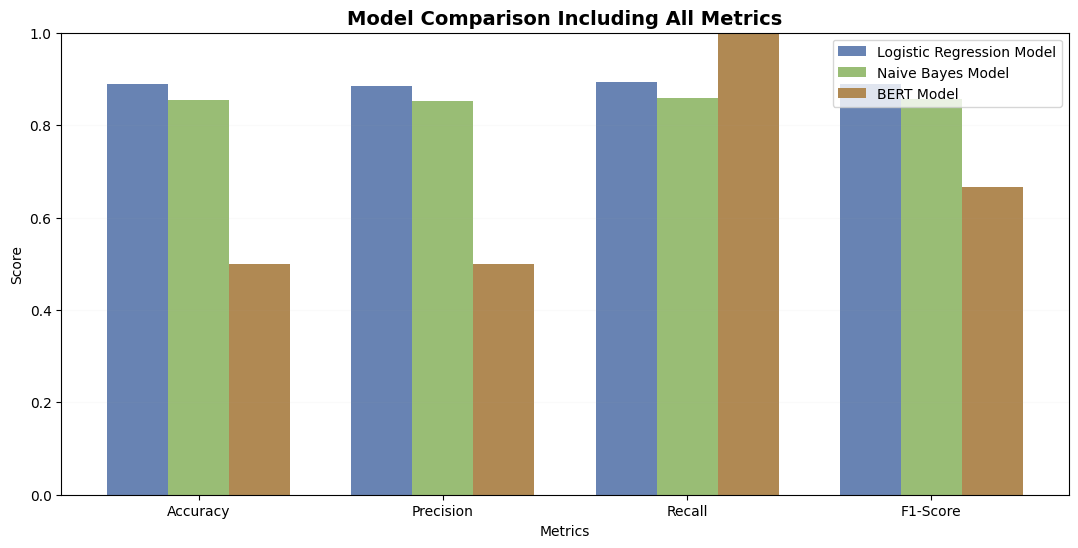

In [68]:
def plot_model_comparison_bar_chart(comparison_df):

    fig, ax = plt.subplots(1, 1)

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    x = np.arange(len(metrics))

    width = 0.25

    bars1 = ax.bar(x - width, comparison_df.iloc[0, 1:], width,
                        label = 'Logistic Regression Model', color = BLUE)
    bars2 = ax.bar(x, comparison_df.iloc[1, 1:], width,
                        label = 'Naive Bayes Model', color = GREEN)
    bars3 = ax.bar(x + width, comparison_df.iloc[2, 1:], width,
                        label = 'BERT Model', color = ORANGE)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison Including All Metrics', fontsize = 14, fontweight = 'bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim([0, 1.0])
    ax.grid(axis = 'y', alpha = 0.05)

plot_model_comparison_bar_chart(comparison_df)

In [69]:
# # Add value labels on bars
# for bars in [bars1, bars2, bars3]:
#     for bar in bars:
#         height = bar.get_height()
#         axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
#                     f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# # Accuracy comparison
# models = comparison_df['Model']
# accuracies = comparison_df['Accuracy']

# bars = axes[1].bar(models, accuracies, color=['steelblue', 'coral', 'mediumseagreen'])
# axes[1].set_ylabel('Accuracy')
# axes[1].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
# axes[1].set_ylim([0, 1.0])
# axes[1].grid(axis='y', alpha=0.3)

# # Add value labels
# for bar in bars:
#     height = bar.get_height()
#     axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
#                 f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# # Rotate x labels
# plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=15, ha='right')

# plt.tight_layout()
# plt.savefig(f'{IMG_DIR}/model_comparison.png', dpi = 150, bbox_inches = 'tight')
# plt.show()

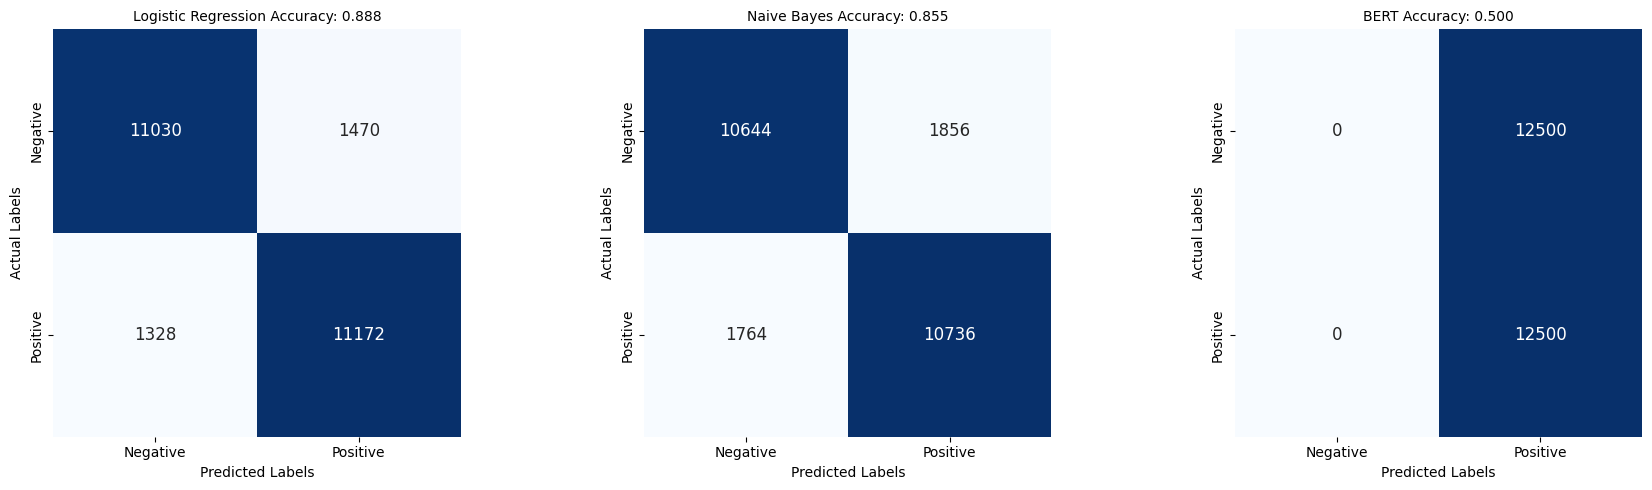

In [70]:
def plot_confusion_matrix():

    fig, ax = plt.subplots(1, 3, figsize = (18, 5))

    models_data = [
        ('Logistic Regression', lr_predictions),
        ('Naive Bayes', nb_predictions),
        ('BERT', bert_predictions)
    ]

    for id, (name, preds) in enumerate(models_data):
        cm = confusion_matrix(y_test if id < 2 else bert_true_labels, preds)

        sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', ax = ax[id],
                    cbar = False, square = True, annot_kws = {'size': 12})
        ax[id].set_title(f'{name} Accuracy: {comparison_df.iloc[id]["Accuracy"]:.3f}',
                        fontsize = 10)
        ax[id].set_xlabel('Predicted Labels')
        ax[id].set_ylabel('Actual Labels')
        ax[id].set_xticklabels(['Negative', 'Positive'])
        ax[id].set_yticklabels(['Negative', 'Positive'])

    plt.tight_layout()
    plt.savefig(f'{IMG_DIR}/confusion_matrices.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

plot_confusion_matrix()

In [71]:
def get_classification_report():

    for name, predictions in [
        ('Logistic Regression', lr_predictions),
        ('Naive Bayes', nb_predictions),
        ('BERT', bert_predictions)]:

        print(name)

        true_labels = y_test if name != 'BERT' else bert_true_labels

        print(classification_report(true_labels, predictions,
                                    target_names = ['Negative', 'Positive']))

get_classification_report()

Logistic Regression
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89     12500
    Positive       0.88      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Naive Bayes
              precision    recall  f1-score   support

    Negative       0.86      0.85      0.85     12500
    Positive       0.85      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

BERT
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     12500
    Positive       0.50      1.00      0.67     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [72]:
# Calculating BERT model accuracy increase
def calculaye_bert_accuracy_increase(original_accuracy, new_accuracy = bert_accuracy):
    return ((new_accuracy - original_accuracy) / original_accuracy) * 100

lr_to_bert_improvement = calculaye_bert_accuracy_increase(lr_accuracy)
nb_to_bert_improvement = calculaye_bert_accuracy_increase(nb_accuracy)

print(f"BERT Improvements:")
print(f"Compared to Logistic Regression: + {lr_to_bert_improvement:.2f}% accuracy")
print(f"Compared to Naive Bayes: + {nb_to_bert_improvement:.2f}% accuracy")

BERT Improvements:
Compared to Logistic Regression: + -43.70% accuracy
Compared to Naive Bayes: + -41.53% accuracy


In [73]:
# Model,Accuracy,Precision,Recall,F1-Score
# Logistic Regression,0.8884,0.8840373358645784,0.89408,0.889030307851404
# Naive Bayes,0.8554,0.8527193330686781,0.8592,0.8559473998804543
# BERT (Fine-tuned),0.5,0.5,1.0,0.6666666666666666

## Modifying Traning Parameters (HYPER PARAMETER TUNING)

In [74]:
# Further Reducing learning Rate

optimizer = AdamW(
    model.parameters(),
    lr = 2e-5, # 0.001,
    eps = 1e-8,
    weight_decay = 0.01
)

In [75]:
sum_steps = len(train_loader) * 3
warmup_steps = 500

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = warmup_steps,
    num_training_steps = sum_steps
)

In [76]:
for epoch in range(3):

    model.train()

    # For tracking training progress
    total_train_loss = 0
    train_predictions = []
    train_true_labels = []

    print(f"Epoch {epoch + 1}/{3} - Training...")

    for batch_num, batch in enumerate(train_loader):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        model.zero_grad()

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            labels = labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        scheduler.step()

        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim = 1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        train_predictions.extend(preds)
        train_true_labels.extend(labels_cpu)

        if (batch_num + 1) % 10 == 0:
            print(f"Batch {batch_num + 1}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_true_labels, train_predictions)

    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")

    print("Evaluating on test set...")

    # Model Evaluation
    model.eval()

    total_val_loss = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch_num, batch in enumerate(test_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels_cpu = labels.cpu().numpy()

            val_predictions.extend(preds)
            val_true_labels.extend(labels_cpu)

            if (batch_num + 1) % 10 == 0:
                print(f"Batch {batch_num + 1}/{len(test_loader)}")

    avg_val_loss = total_val_loss / len(test_loader)
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        val_true_labels,
        val_predictions,
        average = 'binary'
    )

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f}")

    # Storing stats for later plotting and persisting (saving) to storage
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': avg_val_loss,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })

Epoch 1/3 - Training...
Batch 10/3125 - Loss: 0.8756
Batch 20/3125 - Loss: 0.8612
Batch 30/3125 - Loss: 0.5757
Batch 40/3125 - Loss: 0.6829
Batch 50/3125 - Loss: 1.0273
Batch 60/3125 - Loss: 0.5592
Batch 70/3125 - Loss: 0.9023
Batch 80/3125 - Loss: 0.4990
Batch 90/3125 - Loss: 0.4909
Batch 100/3125 - Loss: 0.6435
Batch 110/3125 - Loss: 0.7286
Batch 120/3125 - Loss: 0.8162
Batch 130/3125 - Loss: 0.6805
Batch 140/3125 - Loss: 0.8408
Batch 150/3125 - Loss: 0.7644
Batch 160/3125 - Loss: 0.8959
Batch 170/3125 - Loss: 0.7476
Batch 180/3125 - Loss: 0.8173
Batch 190/3125 - Loss: 0.7234
Batch 200/3125 - Loss: 0.5558
Batch 210/3125 - Loss: 0.6357
Batch 220/3125 - Loss: 0.8441
Batch 230/3125 - Loss: 0.6726
Batch 240/3125 - Loss: 0.6965
Batch 250/3125 - Loss: 0.6928
Batch 260/3125 - Loss: 0.6416
Batch 270/3125 - Loss: 0.7544
Batch 280/3125 - Loss: 0.7800
Batch 290/3125 - Loss: 0.7791
Batch 300/3125 - Loss: 0.6593
Batch 310/3125 - Loss: 0.6939
Batch 320/3125 - Loss: 0.8192
Batch 330/3125 - Loss: 0.

Get Post Traning Statistics and Plot Graphs

In [90]:
comparison_df2 = compare_models()

lr_to_bert_improvement = calculaye_bert_accuracy_increase(lr_accuracy)
nb_to_bert_improvement = calculaye_bert_accuracy_increase(nb_accuracy)

print(f"BERT Improvements:")
print(f"Compared to Logistic Regression: + {lr_to_bert_improvement:.2f}% accuracy")
print(f"Compared to Naive Bayes: + {nb_to_bert_improvement:.2f}% accuracy")

              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression   0.88808   0.883721 0.89376  0.888712
        Naive Bayes   0.85520   0.852605 0.85888  0.855731
  BERT (Fine-tuned)   0.85820   0.850270 0.86952  0.859787
Comparison saved to images/model_comparison.csv
BERT Improvements:
Compared to Logistic Regression: + -3.36% accuracy
Compared to Naive Bayes: + 0.35% accuracy


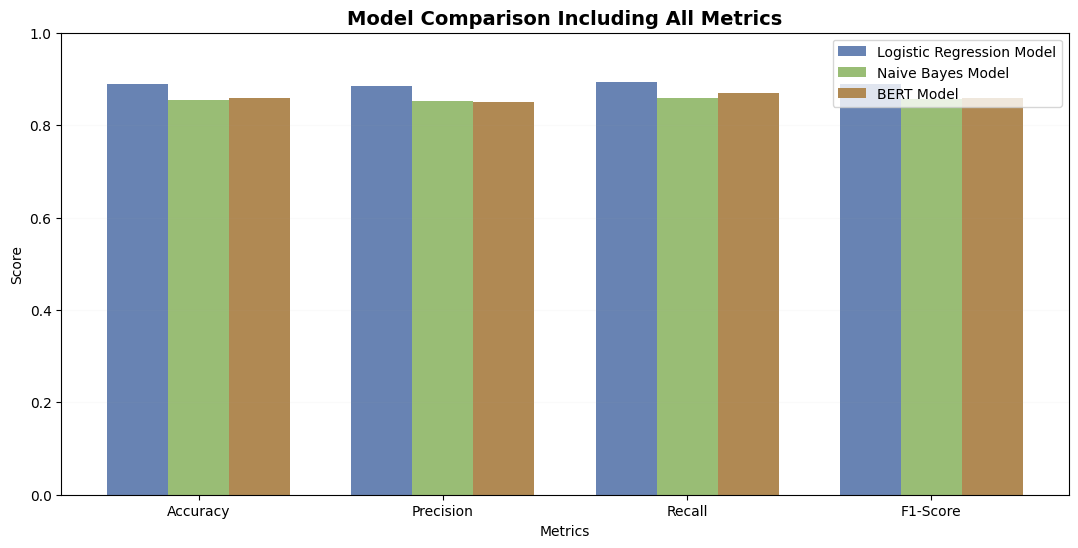

In [94]:
plot_model_comparison_bar_chart(comparison_df2)

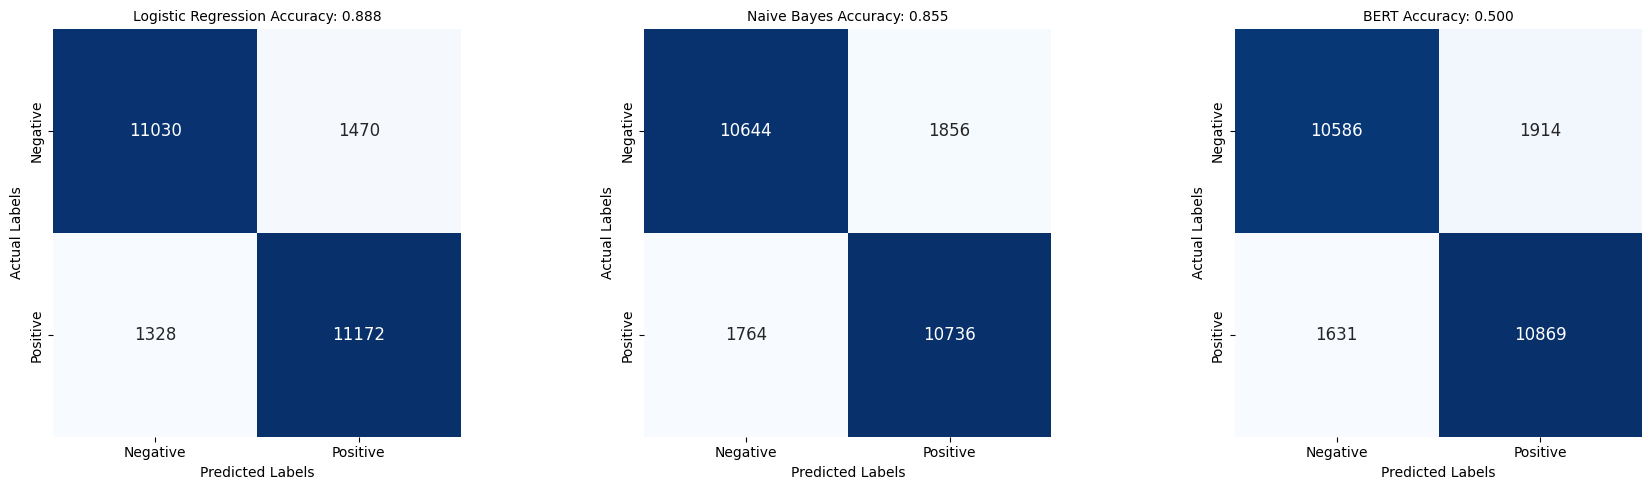

In [88]:
plot_confusion_matrix()

In [89]:
get_classification_report()

Logistic Regression
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89     12500
    Positive       0.88      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Naive Bayes
              precision    recall  f1-score   support

    Negative       0.86      0.85      0.85     12500
    Positive       0.85      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

BERT
              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86     12500
    Positive       0.85      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86    

In [87]:
lr_to_bert_improvement = calculaye_bert_accuracy_increase(lr_accuracy)
nb_to_bert_improvement = calculaye_bert_accuracy_increase(nb_accuracy)

print(f"Hypertuned BERT Improvements:")
print(f"Compared to Logistic Regression: + {lr_to_bert_improvement:.2f}% accuracy")
print(f"Compared to Naive Bayes: + {nb_to_bert_improvement:.2f}% accuracy")

Hypertuned BERT Improvements:
Compared to Logistic Regression: + -3.36% accuracy
Compared to Naive Bayes: + 0.35% accuracy


Naive Bayes Results
Precision: 0.8526
Accuracy: 0.8552
Recall: 0.8589
F1-Score: 0.8557


In [ ]:
stats_df = pd.DataFrame(training_stats)

stats_output_path = os.path.join(IMG_DIR, 'bert_training_stats.csv')
stats_df.to_csv(stats_output_path, index = False)

print(f"Training statistics saved to {stats_output_path}")

In [85]:
model.eval()
bert_predictions = []
bert_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc = "BERT Inference"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim = 1).cpu().numpy()

        bert_predictions.extend(preds)
        bert_true_labels.extend(labels.cpu().numpy())


bert_accuracy = accuracy_score(bert_true_labels, bert_predictions)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    bert_true_labels,
    bert_predictions,
    average = 'binary'
)

print(f"Hypertuned BERT Results:")
print(f"Accuracy: {bert_accuracy:.4f}")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall: {bert_recall:.4f}")
print(f"F1-Score: {bert_f1:.4f}")

BERT Inference:   0%|          | 0/3125 [00:00<?, ?it/s]

Hypertuned BERT Results:
Accuracy: 0.8582
Precision: 0.8503
Recall: 0.8695
F1-Score: 0.8598


In [86]:
def calculaye_bert_accuracy_increase(original_accuracy, new_accuracy = bert_accuracy):
    return ((new_accuracy - original_accuracy) / original_accuracy) * 100

lr_to_bert_improvement = calculaye_bert_accuracy_increase(lr_accuracy)
nb_to_bert_improvement = calculaye_bert_accuracy_increase(nb_accuracy)

print(f"BERT Improvements:")
print(f"Compared to Logistic Regression: + {lr_to_bert_improvement:.2f}% accuracy")
print(f"Compared to Naive Bayes: + {nb_to_bert_improvement:.2f}% accuracy")

BERT Improvements:
Compared to Logistic Regression: + -3.36% accuracy
Compared to Naive Bayes: + 0.35% accuracy
